In [4]:
from sklearn import preprocessing
from collections import deque
from datetime import datetime
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

drive_path = f'/home/csand/crypto-bot/'

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# ratios = ["BTCUSDT", "ETHUSDT", "NANOUSDT"]
ratios = ["BTCUSDT", "LTCUSDT", "ETHUSDT", "BNBUSDT",
          "ADAUSDT", "BTTUSDT", "DASHUSDT", "XMRUSDT",
          "NANOUSDT", "DOGEUSDT", "XLMUSDT", "BCHUSDT"]
RATIO_TO_PREDICT = "BTCUSDT"

SEQ_LEN = 48
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 40
BATCH_SIZE = 64
current_time = datetime.utcnow().strftime('%Y-%m-%d %H-%M-%S')
NAME = f"LSTM-{current_time}"

def construct_main_df(ratios):
    main_df = pd.DataFrame()
    # 'unix,date,symbol,open,high,low,close,Volume LTC,Volume USDT,tradecount'
    for ratio in ratios:
        dataset = f"{drive_path}data/Binance_{ratio}_1h.csv"
        df = pd.read_csv(dataset, nrows=None, skiprows=None, parse_dates=['date'], usecols=[0, 1, 2])  # todo
        df.set_index("date", inplace=True)

        if len(main_df) == 0:
            main_df = df
        else:
            main_df = main_df.join(df)

    # in this case it reduces main_df length to the length of pair with the smallest data
    main_df.dropna(how='any', inplace=True)

    # we determine targets by making ['future'] column with shifted rows,
    # and then if its price is higher than current day setting ['target'] to 1, and 0 otherwise
    main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
    main_df['target'] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
    main_df.drop('future', 1, inplace=True)  # future column is no longer needed, used only to determine target column
    # rows with future = NaN also are dropped here
    return main_df

def classify(current, future):
    return 1 if float(future) > float(current) else 0

def split_main_df(main_df, train_split, validation_split, test_split):
    # [train train train train_index val val val val_index test test test_index]
    train_index = int(train_split * len(main_df))  # last indexes
    validation_index = int(train_index + validation_split * len(main_df))
    test_index = test_split  # we don't really need to use it, its always the last index

    train_df = main_df.iloc[:train_index]
    validation_df = main_df.iloc[train_index:validation_index]
    test_df = main_df.iloc[validation_index:]
    return train_df, validation_df, test_df

# percentage change and scaling
def preprocess_data(df):
    df = df.copy()  # fixes random SettingWithCopyWarning appearing with pct_change and preprocessing.scale
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()  # converted to percentage change
            # example:
            # hour 1:00 close = 93.13, hour 2:00 close = 92.41, so
            # 93.13 + 93.13 * x = 92.41, x = -0.007731
            # so percentage change of 1.0 means doubling the price
            # first row (the oldest values) is being filled with NaN percentage, but we don't want to drop whole row yet
            # so we wait until loop ends (we will have whole row filled with nans)
    df.dropna(inplace=True)
    # print('b', df.shape, df.isnull().values.any())
    for col in df.columns:
        if col != "target":
            # scaling should be used after splitting to training and test set - leaks data from test set to training
            df[col] = preprocessing.scale(df[col].values)  # normalizes to [-1, +1]
            # df[col] = preprocessing.StandardScaler().fit_transform(df[col].values.reshape(-1, 1)) # it does the same
            # scales the data so it has mean = 0, standard deviation = 1, variance = 1
            # it can be checked before and after with e.g. print(df['BTCUSDT_close'].mean())  .std()  .var()

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)  # list of SEQ_LEN items, we append to it, as it exceed, it pops old values

    for i in df.values:
        prev_days.append([n for n in i[:-1]])  # set of price and volume features added (-1 so without target)
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
    # print(len(sequential_data))
    # ok so the sequences are like this ([a, b, 1] is single prev_days) (* and ^ just to point where it goes):
    # [([[a, b] [c, d], [e, f]], 1*)   ([[c, d] [e, f] [g, h]], 1) ... ([[g, h], [i, j], [k, l]], 0^)]
    random.shuffle(sequential_data)


    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys + sells  # concatenate lists
    random.shuffle(
        sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    return np.array(x), np.array(y)

In [6]:
time0 = time.perf_counter()
main_df = construct_main_df(ratios)
print(main_df.shape)
time1 = time.perf_counter()
print(time1 - time0)

train_df, validation_df, test_df = split_main_df(main_df, train_split=0.6, validation_split=0.2, test_split=0.2)
print(train_df.shape, validation_df.shape, test_df.shape)
time2 = time.perf_counter()
print(time2 - time1)

train_x, train_y = preprocess_data(train_df)
validation_x, validation_y = preprocess_data(validation_df)
test_x, test_y = preprocess_data(test_df)
time3 = time.perf_counter()
print(train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape,)
print(time3 - time2)

/tmp/ipykernel_3576361/60053384.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  main_df.drop('future', 1, inplace=True)  # future column is no longer needed, used only to determine target column


(21884, 25)
0.9603793229907751
(13130, 25) (4376, 25) (4378, 25)
0.037155180936679244
(13004, 48, 24) (13004,) (4220, 48, 24) (4220,) (404, 48, 24) (404,)
4.556970745092258


In [7]:
def build_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    # i cannot save CuDNNLSTM due to some error, not using it
    # model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
    # opt = tf.keras.optimizers.Adam()

    model.compile(loss = "sparse_categorical_crossentropy", 
                  optimizer=opt,
                  metrics=['accuracy'])

    print(model.summary())
    return model
model = build_model()

2021-11-17 08:39:37.886408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-17 08:39:37.886585: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-17 08:39:37.886696: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vmi566227.contaboserver.net): /proc/driver/nvidia/version does not exist
2021-11-17 08:39:37.887706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 128)           78336     
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 48, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 48, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 48, 128)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 128)          512       
 hNormalization)                                        

In [8]:
checkpoint = ModelCheckpoint(filepath=f"models/{NAME}", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones
earlystopping = EarlyStopping(monitor='val_loss', patience=4)
cb = [checkpoint, earlystopping]

history = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(validation_x, validation_y),
        callbacks=cb)


Epoch 1/40
204/204 [==============================] - ETA: 0s - loss: 0.7588 - accuracy: 0.5386
Epoch 00001: val_accuracy improved from -inf to 0.51469, saving model to models/LSTM-2021-11-17 07-39-18


2021-11-17 08:43:25.332771: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 232s 1s/step - loss: 0.7588 - accuracy: 0.5386 - val_loss: 0.6919 - val_accuracy: 0.5147
Epoch 2/40
204/204 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6089
Epoch 00002: val_accuracy did not improve from 0.51469
204/204 [==============================] - 189s 925ms/step - loss: 0.6364 - accuracy: 0.6089 - val_loss: 0.6932 - val_accuracy: 0.5109
Epoch 3/40
204/204 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.6609
Epoch 00003: val_accuracy improved from 0.51469 to 0.54408, saving model to models/LSTM-2021-11-17 07-39-18


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 207s 1s/step - loss: 0.5635 - accuracy: 0.6609 - val_loss: 0.6762 - val_accuracy: 0.5441
Epoch 4/40
204/204 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.6797
Epoch 00004: val_accuracy did not improve from 0.54408
204/204 [==============================] - 188s 922ms/step - loss: 0.5443 - accuracy: 0.6797 - val_loss: 0.6927 - val_accuracy: 0.5095
Epoch 5/40
204/204 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.6876
Epoch 00005: val_accuracy improved from 0.54408 to 0.54550, saving model to models/LSTM-2021-11-17 07-39-18


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 215s 1s/step - loss: 0.5327 - accuracy: 0.6876 - val_loss: 0.6751 - val_accuracy: 0.5455
Epoch 6/40
204/204 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.6902
Epoch 00006: val_accuracy did not improve from 0.54550
204/204 [==============================] - 188s 924ms/step - loss: 0.5270 - accuracy: 0.6902 - val_loss: 0.6765 - val_accuracy: 0.5412
Epoch 7/40
204/204 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.7009
Epoch 00007: val_accuracy improved from 0.54550 to 0.55237, saving model to models/LSTM-2021-11-17 07-39-18


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 208s 1s/step - loss: 0.5196 - accuracy: 0.7009 - val_loss: 0.6743 - val_accuracy: 0.5524
Epoch 8/40
204/204 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.6939
Epoch 00008: val_accuracy improved from 0.55237 to 0.55924, saving model to models/LSTM-2021-11-17 07-39-18


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 210s 1s/step - loss: 0.5166 - accuracy: 0.6939 - val_loss: 0.6732 - val_accuracy: 0.5592
Epoch 9/40
204/204 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7075
Epoch 00009: val_accuracy did not improve from 0.55924
204/204 [==============================] - 184s 904ms/step - loss: 0.5057 - accuracy: 0.7075 - val_loss: 0.6780 - val_accuracy: 0.5275
Epoch 10/40
204/204 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.7138
Epoch 00010: val_accuracy did not improve from 0.55924
204/204 [==============================] - 187s 918ms/step - loss: 0.4968 - accuracy: 0.7138 - val_loss: 0.6789 - val_accuracy: 0.5365
Epoch 11/40
204/204 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.7134
Epoch 00011: val_accuracy did not improve from 0.55924
204/204 [==============================] - 186s 913ms/step - loss: 0.4972 - accuracy: 0.7134 - val_loss: 0.6730 - val_accuracy: 0.5581
Epoch 12

INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-11-17 07-39-18/assets


204/204 [==============================] - 206s 1s/step - loss: 0.4906 - accuracy: 0.7197 - val_loss: 0.6731 - val_accuracy: 0.5607
Epoch 13/40
204/204 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.7233
Epoch 00013: val_accuracy did not improve from 0.56066
204/204 [==============================] - 185s 908ms/step - loss: 0.4842 - accuracy: 0.7233 - val_loss: 0.6805 - val_accuracy: 0.5374
Epoch 14/40
204/204 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.7308
Epoch 00014: val_accuracy did not improve from 0.56066
204/204 [==============================] - 187s 915ms/step - loss: 0.4762 - accuracy: 0.7308 - val_loss: 0.6859 - val_accuracy: 0.5514
Epoch 15/40
204/204 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.7352
Epoch 00015: val_accuracy did not improve from 0.56066
204/204 [==============================] - 192s 941ms/step - loss: 0.4676 - accuracy: 0.7352 - val_loss: 0.6964 - val_accuracy: 0.5322


Trained model:
        loss  accuracy  val_loss  val_accuracy
14  0.467647  0.735235  0.696411      0.532228 



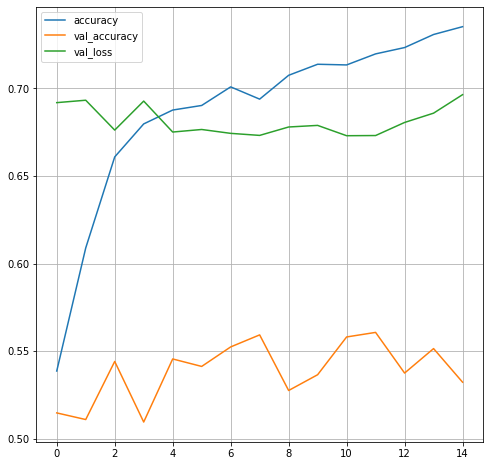

In [9]:
def plot_history(history):
        hist_df = pd.DataFrame(history.history)
        print(f'Trained model:')
        print(hist_df.tail(1), '\n')
        hist_df_short = hist_df[['accuracy', 'val_accuracy', 'val_loss']]
        hist_df_short.plot(figsize=(8,8), grid=True)

plot_history(history)

In [10]:
model_path = f'{drive_path}models/{NAME}'
model.save(model_path)

model = keras.models.load_model(model_path)
score = model.evaluate(test_x, test_y, verbose=10)  # evaluate against unseen test data
print("TEST LOSS:", score[0])
print("TEST ACCURACY:", score[1])

INFO:tensorflow:Assets written to: /home/csand/crypto-bot/models/LSTM-2021-11-17 07-39-18/assets


INFO:tensorflow:Assets written to: /home/csand/crypto-bot/models/LSTM-2021-11-17 07-39-18/assets


TEST LOSS: 0.7767418622970581
TEST ACCURACY: 0.39603960514068604


In [12]:
#import tensorflow as tf
#from config import MODEL_PATH

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)  # path to the SavedModel directory
converter.experimental_new_converter = True
converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save it
with open('model2.tflite', 'wb') as f:
    print("Started writing")
    f.write(tflite_model)
    print("Finished")



2021-11-17 09:33:58.983800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-17 09:33:58.983967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-17 09:33:58.983975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2021-11-17 09:33:58.984521: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /home/csand/crypto-bot/models/LSTM-2021-11-17 07-39-18
2021-11-17 09:33:59.096647: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-11-17 09:33:59.096748: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /home/csand/crypto-bot/models/LSTM-2021-11-17 07-39-18
2021-11-17 09:33:59.590719: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-11-17 09:34:00.289759: I tensorflow/cc/saved_model/loader.cc:194]

Started writing
Finished
